In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler

import argparse
import random
import os
import math

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# CUDA support
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else:
        raise ValueError(f'unknown activation function: {name}')

In [5]:
seed_torch(24)

In [6]:
class MLP(nn.Module):
    """Deep Neural Network"""

    def __init__(self, L, M, dim_hidden, hidden_layers, dim_out,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__()
        
        dim_in = M * 2 + 2
        
        model = nn.Sequential()
        
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))
            
        self.model = model
        
        self.L = L
        self.M = M
        
        if init_name is not None:
            self.init_weight(init_name)

            
        self.k = nn.Parameter(torch.arange(1, self.M+1), requires_grad=False)
                    
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
                
#         for layer, param in enumerate(self.parameters()):
#             if layer % 2 == 1:
#                 nn.init.constant_(param, 0.0)
#             else:
#                 nn_init(param)
                
    def input_encoding(self, t, x):
        w = 2.0 * math.pi / self.L
        out = torch.cat([t, torch.ones_like(t), 
                            torch.cos(self.k * w * x), torch.sin(self.k * w * x)], dim = 1) 
        
        return out    
            
    def forward(self, H):
        t = H[:, 0:1]
        x = H[:, 1:2]
        
        H = self.input_encoding(t, x)
        H = self.model(H)
        
        return H
    
    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x

    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params
    
    def print(self):
        print(self.bias)

In [7]:
model = MLP(L=2.0, M=10, dim_hidden=128, hidden_layers=4, dim_out=1)

KDV方程：
$$
\left\{\begin{matrix}
&u_{t}+ \lambda_1 u u_{x} + \lambda_2 u_{xxx}=0  ,(t,x)\in (0,1)\times (-1,1),  \\
&u(0,x)= cos(\pi x),  \\
&u(t,-1)=u(t,1),t\in [0,1],  \\
&u_x(t,-1)=u_x(t,1),x\in [0,1].
\end{matrix}\right.
$$
$\lambda_1 = 1.000$, $\lambda_2 = 0.0025$.

## Options

In [17]:
import argparse
class Options_KDV(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=12, help='neurons in hidden layers')     # 10 9
        parser.add_argument('--hidden_layers', type=int, default=9, help='number of hidden layers')    # 4  20
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=0.001, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=300000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=2500, help='epochs for LBFGS optimizer')
        parser.add_argument('--newton_iter', type=int, default=100, help='newton_iter for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=50000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.9, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--tol', type=float, default=100, help='the annealing scheme')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')

        self.parser = parser

    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.load_model = False
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        # arg.cuda = False
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(arg.cuda)
        print(arg.device)
        return arg

args = Options_KDV().parse()
print(args.hidden_layers)

def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

True
cuda
9


In [18]:
model.to(device)
args.model=model

## 数据集生成

In [19]:
class Trainset_KDV():
    '''
    训练点:时间剖分 100 段， 空间上分成25段，每段上取4个高斯点
    '''
    def __init__(self, *args):
        self.args = args
        self.shape = (self.args[0], self.args[1])
        
    def __call__(self):
        return self.data()
    
    def data(self):
        # 为了生成高斯积分点，n_x一定要是4的倍数
        gp = np.array([0.8611363116,-0.8611363116,0.3399810436,-0.3399810436])
        gc = np.array([0.3478548451,0.3478548451,0.6521451549,0.6521451549])
        n_t = self.args[0]
        n_x = self.args[1]
        n_ics = self.args[2]
        
        # 生成初值训练点
        t = np.linspace(0, 1, n_t)
        x = np.linspace(-1, 1, n_x)
        x, t = np.meshgrid(x, t)
        tx = np.hstack((t.reshape(-1,1), x.reshape(-1,1)))

        t_ics = np.zeros(n_ics)
        x_ics = np.linspace(-1, 1, n_ics)
        tx_ics = np.hstack([t_ics.reshape(-1,1),x_ics.reshape(-1,1)])
        
        u_ics = np.cos(math.pi*x_ics)
        u_ics = u_ics.reshape(-1,1)
        M = np.triu(np.ones([n_t, n_t]),k=1).T
        
        # 生成tgx(高斯训练点)
        num_cell = int(n_x/4 + 1)
        l = np.linspace(-1, 1, num_cell)[:, None]
        l = np.hstack([l[:-1], l[1:]])
        c = (l[:, 1] - l[:, 0])/2
        c = c[:, None]
        gp = gp[None, :]
        d = ((l[:, 1] + l[:, 0])/2)
        d = d[:, None]
        n_p = c * gp + d  # n_p是100个高斯积分点
        n_p = n_p.reshape(n_x, 1)
        gcl = c * gc     # gcl是这100个高斯积分点对应的权重  
        gcl = gcl.reshape(n_x, 1)
        t = np.linspace(0, 1, n_t)[:, None]
        x, t = np.meshgrid(n_p, t) #   mesh size (128, 100)
        print(x.shape)
        txg = np.hstack([t.reshape(-1, 1), x.reshape(-1, 1)])
        # 计算一下初始能量
        E2 =  np.cos(math.pi*n_p) ** 2 * gcl
        E2 = np.sum(E2)
        print(E2)
        
        tx = torch.from_numpy(tx).float().to(device)
        txg = torch.from_numpy(txg).float().to(device)
        
        tx_ics = torch.from_numpy(tx_ics).float().to(device)
        u_ics = torch.from_numpy(u_ics).float().to(device)
        M = torch.from_numpy(M).float().to(device)
        
        return tx, tx_ics, u_ics, M, gcl, txg, E2

In [20]:
# 构造一个预测网格
# load the data
data = scipy.io.loadmat('../data/KdV.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]

In [21]:
print(t_star.shape)
print(x_star.shape)
X_pred = np.hstack([np.ones((len(x_star),1)) * t_star[0 + 1], x_star.reshape(-1,1)])
pred = np.zeros((512, 201))

(201,)
(512,)


In [22]:
# 把初值填在第一列
pred[:, 0] = np.cos(math.pi * x_star)

In [23]:
nt = t_star.shape[0]
nx = 100
n_ics = 100

In [24]:
# tgx是高斯点的数据集， shape :(12800, 2) 第一列代表时间，第二列代表空间 ，前100个点表示t = 0 时刻上的采样点，第101个到200表示t = 1/nt 时刻的采样点， 依次类推
trainset = Trainset_KDV(nt, nx, n_ics)
args.trainset = trainset
tx, tx_ics, u_ics, M, gcl, txg, E2 = trainset()  # E2 是初始时刻的平方积分

(201, 100)
0.9999999999999998


## 训练

In [25]:
class Trainer_Wave(object):
    def __init__(self, args):
        self.model = args.model
        self.lr = args.lr
        self.gamma = args.gamma
        self.trainset = args.trainset
        self.step_size = args.step_size
        self.model_name = self.model.__class__.__name__     
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999))
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=self.gamma)
        self.epochs_Adam = args.epochs_Adam
        self.tol = args.tol
        
        # data
        self.tx, self.tx_ics, self.u_ics, self.M,  self.gcl, self.txg, self.E2 = self.trainset()
        self.gcl = torch.from_numpy(self.gcl).float().to(device)
        self.E2 = torch.tensor(self.E2).float().to(device)
        self.nx = nx
        self.nt = nt
        
        # Logger
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.loss_energy_log = []
        self.epoch_log = []
        
        self.x_pred = x_star
        self.t_pred = t_star
        self.pred = pred  # (512, 201)

    def net_r(self, tx):
        tx.requires_grad_(True).to(device)
        u = self.model(tx)
        grad_u = grad(u, tx)[0]
        u_t = grad_u[:,[0]]
        u_x = grad_u[:,[1]]
        u_xx = grad(u_x, tx)[0][:, [1]]
        u_xxx = grad(u_xx, tx)[0][:, [1]]

        residual = u_t  + u * u_x + 0.0025 * u_xxx

        return residual

    def net_u(self, tx):
        u = self.model(tx)  
        return u
    
    def loss_ics(self, X, u_ics):
        u_pred = self.net_u(X)
        loss_ics = torch.mean((u_pred - u_ics)**2)
        return loss_ics
    
    def loss_res(self, X):
        r_pred = self.net_r(X)
        loss_r = torch.mean(r_pred**2)
        return loss_r
    
    def energy_loss(self, X):
        q_pred = self.net_u(X)
        num_t = int(len(X)/self.nx)
        q_pred = q_pred.reshape(num_t, 100)
        if self.gcl.shape != (1, 100):
            self.gcl = self.gcl.reshape(1, 100)
        q_pred = q_pred ** 2 * self.gcl
        q_pred = torch.sum(q_pred, axis=1)
        q_pred = (q_pred - self.E2)
        loss_q = torch.mean(q_pred ** 2)
        return loss_q
        
    def loss(self, X0, u_ics, X1):
        if X0[0, 0] == 0:
            L0 = 100 * self.loss_ics(X0, u_ics)
        else:
            L0 = self.loss_ics(X0, u_ics)
        loss = L0 + self.loss_res(X1) + 10 * self.energy_loss(X1)    
        return loss
    
    def predict(self, X):
        X = torch.tensor(X).float().to(device)
        pred_u = self.net_u(X)
        pred_u = pred_u.cpu().detach().numpy()
        return pred_u
    
    def train(self):
        start = time.time()
        for i in range(0, self.nt - 1):
            X_train = self.txg[i*100 : (i + 2)*100]
            X_init = X_train[:100]
            X_next = X_train[-100:]
            for epoch in range(self.epochs_Adam):
                self.optimizer_Adam.zero_grad()
                if i == 0:
                    loss_value = self.loss(self.tx_ics, self.u_ics, X_train)
                else:
                    loss_value = self.loss(X_init, u_ics_pred, X_train)
                if loss_value < 1e-6:
                    print(f'i :{i}' + f' Epoch # {epoch}/{self.epochs_Adam}' + f'loss:{loss_value:.2e}')
                    X_pred = np.hstack([np.ones((len(self.x_pred),1)) * self.t_pred[i + 1], self.x_pred.reshape(-1,1)])
                    U_pred = self.predict(X_pred)
                    self.pred[:, [i+1]] = U_pred
                    break
                else:
                    loss_value.backward()
                    self.optimizer_Adam.step()
                    if (epoch+1) % self.step_size == 0:
                        self.scheduler.step()            
                    if epoch % 1000 == 0:
                        if i == 0:
                            loss_ics_value = self.loss_ics(self.tx_ics, self.u_ics)
                        else:
                            loss_ics_value = self.loss_ics(X_init, u_ics_pred)
                        loss_res_value = self.loss_res(X_train)
                        loss_energy = self.energy_loss(X_train)

                        self.loss_log.append(loss_value.detach().cpu())
                        self.loss_ics_log.append(loss_ics_value.detach().cpu())
                        self.loss_res_log.append(loss_res_value.detach().cpu())
                        self.loss_energy_log.append(loss_energy.detach().cpu())
                        self.epoch_log.append(epoch)

                        end = time.time()
                        running_time = end - start
                        start = time.time()

                        print(f'Epoch #  {epoch}/{self.epochs_Adam}' + f'    time:{running_time:.2f}' + '\n' + \
                              f'loss:{loss_value:.2e}, loss_ics:{loss_ics_value:.2e}, loss_res:{loss_res_value:.2e}, loss_energy:{loss_energy:.2e}')
            u_ics_pred = self.predict(X_next)
            u_ics_pred = torch.tensor(u_ics_pred).float().to(device)
            #scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=0.9)

In [26]:
trainer = Trainer_Wave(args)

(201, 100)
0.9999999999999998


In [ ]:
trainer.train()

Epoch #  0/300000    time:0.58
loss:2.58e+02, loss_ics:5.80e-01, loss_res:3.92e+01, loss_energy:7.36e-01
Epoch #  1000/300000    time:27.46
loss:8.77e-03, loss_ics:7.54e-05, loss_res:1.22e-03, loss_energy:2.56e-07
Epoch #  2000/300000    time:30.74
loss:1.24e-02, loss_ics:4.08e-05, loss_res:8.73e-03, loss_energy:3.34e-06
Epoch #  3000/300000    time:33.37
loss:3.54e-03, loss_ics:2.86e-05, loss_res:8.42e-04, loss_energy:2.11e-07
Epoch #  4000/300000    time:33.84
loss:5.70e-02, loss_ics:3.06e-05, loss_res:6.92e-02, loss_energy:7.18e-07
Epoch #  5000/300000    time:29.90
loss:6.19e-03, loss_ics:1.00e-05, loss_res:2.43e-03, loss_energy:1.17e-06
Epoch #  6000/300000    time:28.17
loss:7.13e-04, loss_ics:4.52e-06, loss_res:2.55e-04, loss_energy:9.34e-08
Epoch #  7000/300000    time:31.61
loss:2.69e-02, loss_ics:2.39e-05, loss_res:1.80e-02, loss_energy:1.08e-04
Epoch #  8000/300000    time:35.41
loss:5.46e-04, loss_ics:1.12e-06, loss_res:2.82e-04, loss_energy:1.64e-09
Epoch #  9000/300000   

/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


i :1 Epoch # 105/300000loss:9.26e-07
Epoch #  0/300000    time:4.30
loss:1.16e-05, loss_ics:2.21e-08, loss_res:1.08e-05, loss_energy:7.42e-09
i :2 Epoch # 105/300000loss:9.82e-07
Epoch #  0/300000    time:3.77
loss:1.33e-05, loss_ics:2.77e-08, loss_res:9.71e-06, loss_energy:1.03e-08
i :3 Epoch # 140/300000loss:9.93e-07
Epoch #  0/300000    time:5.45
loss:1.30e-05, loss_ics:2.71e-08, loss_res:1.08e-05, loss_energy:7.14e-09
i :4 Epoch # 122/300000loss:9.98e-07
Epoch #  0/300000    time:3.80
loss:1.36e-05, loss_ics:2.91e-08, loss_res:1.06e-05, loss_energy:8.22e-09
i :5 Epoch # 179/300000loss:9.61e-07
Epoch #  0/300000    time:5.43
loss:1.30e-05, loss_ics:3.09e-08, loss_res:1.30e-05, loss_energy:7.16e-09
i :6 Epoch # 150/300000loss:9.97e-07
Epoch #  0/300000    time:5.36
loss:1.35e-05, loss_ics:2.71e-08, loss_res:1.22e-05, loss_energy:1.95e-09
i :7 Epoch # 163/300000loss:1.00e-06
Epoch #  0/300000    time:6.39
loss:1.31e-05, loss_ics:2.51e-08, loss_res:1.08e-05, loss_energy:1.73e-09
i :8 E

i :38 Epoch # 333/300000loss:9.95e-07
Epoch #  0/300000    time:11.18
loss:1.69e-05, loss_ics:3.18e-07, loss_res:5.19e-05, loss_energy:1.24e-07
i :39 Epoch # 363/300000loss:1.00e-06
Epoch #  0/300000    time:10.74
loss:1.87e-05, loss_ics:3.26e-07, loss_res:5.57e-05, loss_energy:1.02e-07
Epoch #  1000/300000    time:34.19
loss:1.72e-04, loss_ics:6.03e-06, loss_res:1.38e-04, loss_energy:2.17e-06
Epoch #  2000/300000    time:35.65
loss:1.39e-05, loss_ics:8.27e-07, loss_res:1.30e-05, loss_energy:3.20e-07
Epoch #  3000/300000    time:39.42
loss:2.29e-04, loss_ics:4.98e-06, loss_res:1.99e-04, loss_energy:6.11e-07
Epoch #  4000/300000    time:36.18
loss:4.34e-05, loss_ics:5.94e-06, loss_res:4.48e-06, loss_energy:3.66e-08
i :40 Epoch # 4065/300000loss:9.92e-07
Epoch #  0/300000    time:1.80
loss:1.66e-05, loss_ics:3.26e-07, loss_res:5.63e-05, loss_energy:1.82e-07
Epoch #  1000/300000    time:29.74
loss:4.77e-05, loss_ics:4.67e-06, loss_res:3.10e-05, loss_energy:5.39e-09
Epoch #  2000/300000   

Epoch #  8000/300000    time:37.94
loss:1.16e-06, loss_ics:7.08e-07, loss_res:4.45e-07, loss_energy:7.48e-13
Epoch #  9000/300000    time:32.92
loss:5.16e-06, loss_ics:1.27e-06, loss_res:5.74e-06, loss_energy:2.96e-09
Epoch #  10000/300000    time:31.94
loss:3.52e-04, loss_ics:4.84e-06, loss_res:2.27e-04, loss_energy:6.96e-06
Epoch #  11000/300000    time:36.22
loss:1.12e-04, loss_ics:2.82e-06, loss_res:6.28e-05, loss_energy:2.71e-07
Epoch #  12000/300000    time:37.45
loss:1.92e-05, loss_ics:9.62e-07, loss_res:1.83e-05, loss_energy:3.81e-07
Epoch #  13000/300000    time:38.52
loss:5.14e-05, loss_ics:1.10e-06, loss_res:5.35e-05, loss_energy:6.39e-10
Epoch #  14000/300000    time:30.69
loss:1.51e-06, loss_ics:7.16e-07, loss_res:7.85e-07, loss_energy:1.54e-09
Epoch #  15000/300000    time:36.38
loss:1.04e-04, loss_ics:2.33e-06, loss_res:8.08e-05, loss_energy:1.06e-06
Epoch #  16000/300000    time:38.42
loss:1.12e-04, loss_ics:5.66e-06, loss_res:1.05e-04, loss_energy:2.15e-08
Epoch #  170

Epoch #  22000/300000    time:33.60
loss:1.39e-05, loss_ics:9.16e-07, loss_res:9.16e-06, loss_energy:3.30e-07
Epoch #  23000/300000    time:36.13
loss:5.19e-05, loss_ics:2.92e-06, loss_res:3.37e-05, loss_energy:3.58e-07
Epoch #  24000/300000    time:37.71
loss:2.26e-05, loss_ics:1.08e-06, loss_res:2.06e-05, loss_energy:1.01e-09
Epoch #  25000/300000    time:33.50
loss:1.36e-04, loss_ics:2.15e-06, loss_res:1.53e-04, loss_energy:7.52e-07
Epoch #  26000/300000    time:32.25
loss:3.65e-05, loss_ics:1.66e-06, loss_res:2.75e-05, loss_energy:4.82e-08
Epoch #  27000/300000    time:36.46
loss:4.79e-05, loss_ics:1.61e-05, loss_res:2.90e-05, loss_energy:8.91e-12
Epoch #  28000/300000    time:38.32
loss:2.33e-05, loss_ics:6.76e-07, loss_res:3.68e-05, loss_energy:1.46e-08
Epoch #  29000/300000    time:38.07
loss:7.42e-05, loss_ics:3.74e-06, loss_res:7.96e-05, loss_energy:1.84e-06
Epoch #  30000/300000    time:29.02
loss:9.61e-05, loss_ics:1.97e-06, loss_res:7.07e-05, loss_energy:5.31e-09
Epoch #  3

Epoch #  19000/300000    time:34.52
loss:3.82e-05, loss_ics:2.22e-06, loss_res:4.02e-05, loss_energy:8.68e-08
Epoch #  20000/300000    time:37.73
loss:4.40e-05, loss_ics:1.29e-06, loss_res:5.87e-05, loss_energy:1.41e-07
Epoch #  21000/300000    time:38.90
loss:2.50e-06, loss_ics:9.65e-07, loss_res:1.52e-06, loss_energy:2.56e-13
i :60 Epoch # 21688/300000loss:9.97e-07
Epoch #  0/300000    time:22.21
loss:5.23e-05, loss_ics:1.28e-07, loss_res:1.32e-04, loss_energy:1.43e-09
Epoch #  1000/300000    time:29.89
loss:3.33e-05, loss_ics:6.27e-06, loss_res:1.07e-04, loss_energy:9.86e-07
Epoch #  2000/300000    time:35.32
loss:1.54e-04, loss_ics:7.85e-06, loss_res:4.66e-05, loss_energy:2.98e-07
Epoch #  3000/300000    time:38.73
loss:7.83e-06, loss_ics:1.43e-06, loss_res:5.27e-06, loss_energy:2.19e-07
Epoch #  4000/300000    time:37.76
loss:1.80e-04, loss_ics:7.59e-06, loss_res:8.68e-05, loss_energy:7.47e-07
Epoch #  5000/300000    time:30.68
loss:9.09e-04, loss_ics:5.81e-06, loss_res:1.15e-03, 

Epoch #  14000/300000    time:37.60
loss:1.35e-06, loss_ics:9.38e-07, loss_res:4.13e-07, loss_energy:3.00e-09
Epoch #  15000/300000    time:32.18
loss:5.78e-04, loss_ics:3.90e-06, loss_res:4.42e-04, loss_energy:1.67e-06
Epoch #  16000/300000    time:32.07
loss:1.32e-04, loss_ics:3.53e-06, loss_res:1.34e-04, loss_energy:3.47e-10
Epoch #  17000/300000    time:36.11
loss:1.48e-04, loss_ics:8.76e-06, loss_res:1.09e-04, loss_energy:6.99e-07
Epoch #  18000/300000    time:41.83
loss:3.30e-04, loss_ics:4.32e-05, loss_res:1.79e-04, loss_energy:1.26e-06
i :63 Epoch # 18747/300000loss:9.92e-07
Epoch #  0/300000    time:28.80
loss:5.28e-05, loss_ics:1.20e-07, loss_res:1.23e-04, loss_energy:1.31e-10
Epoch #  1000/300000    time:28.26
loss:2.52e-04, loss_ics:1.01e-05, loss_res:6.75e-05, loss_energy:3.51e-07
Epoch #  2000/300000    time:34.52
loss:1.75e-05, loss_ics:1.20e-06, loss_res:1.50e-05, loss_energy:3.83e-08
Epoch #  3000/300000    time:37.07
loss:1.44e-04, loss_ics:4.67e-06, loss_res:9.91e-05

Epoch #  13000/300000    time:38.28
loss:7.42e-05, loss_ics:2.15e-06, loss_res:5.13e-05, loss_energy:8.96e-07
Epoch #  14000/300000    time:29.94
loss:7.82e-05, loss_ics:7.23e-06, loss_res:4.80e-05, loss_energy:7.78e-07
Epoch #  15000/300000    time:33.64
loss:4.56e-05, loss_ics:2.57e-06, loss_res:1.07e-05, loss_energy:8.52e-08
Epoch #  16000/300000    time:39.25
loss:4.12e-04, loss_ics:3.40e-06, loss_res:2.74e-04, loss_energy:2.32e-09
Epoch #  17000/300000    time:39.44
loss:6.21e-05, loss_ics:1.66e-06, loss_res:6.10e-05, loss_energy:1.02e-09
Epoch #  18000/300000    time:32.27
loss:1.60e-04, loss_ics:1.62e-06, loss_res:1.47e-04, loss_energy:1.26e-06
Epoch #  19000/300000    time:32.93
loss:2.09e-04, loss_ics:4.45e-06, loss_res:2.00e-04, loss_energy:3.62e-07
Epoch #  20000/300000    time:35.60
loss:4.38e-05, loss_ics:2.59e-06, loss_res:4.92e-05, loss_energy:2.79e-07
Epoch #  21000/300000    time:38.59
loss:2.87e-06, loss_ics:1.06e-06, loss_res:1.28e-06, loss_energy:9.93e-10
Epoch #  2

Epoch #  46000/300000    time:37.70
loss:3.22e-04, loss_ics:3.13e-06, loss_res:2.95e-04, loss_energy:1.01e-05
Epoch #  47000/300000    time:37.31
loss:1.25e-06, loss_ics:6.82e-07, loss_res:5.66e-07, loss_energy:2.28e-12
Epoch #  48000/300000    time:33.15
loss:9.99e-05, loss_ics:1.30e-06, loss_res:1.00e-04, loss_energy:2.38e-07
Epoch #  49000/300000    time:32.14
loss:1.28e-04, loss_ics:2.69e-06, loss_res:1.42e-04, loss_energy:3.88e-07
Epoch #  50000/300000    time:35.67
loss:1.24e-04, loss_ics:3.45e-06, loss_res:6.16e-05, loss_energy:3.19e-08
i :70 Epoch # 50109/300000loss:1.00e-06
Epoch #  0/300000    time:3.94
loss:8.42e-05, loss_ics:3.42e-07, loss_res:2.61e-04, loss_energy:6.21e-08
i :71 Epoch # 407/300000loss:9.86e-07
Epoch #  0/300000    time:15.23
loss:1.00e-04, loss_ics:6.63e-07, loss_res:3.23e-04, loss_energy:1.05e-07
Epoch #  1000/300000    time:36.74
loss:1.07e-05, loss_ics:8.83e-07, loss_res:1.60e-05, loss_energy:7.40e-11
Epoch #  2000/300000    time:25.88
loss:1.41e-04, lo

Epoch #  1000/300000    time:29.28
loss:1.76e-05, loss_ics:1.58e-06, loss_res:1.40e-05, loss_energy:8.88e-08
Epoch #  2000/300000    time:32.73
loss:1.11e-04, loss_ics:1.85e-06, loss_res:1.01e-04, loss_energy:5.89e-07
Epoch #  3000/300000    time:37.54
loss:5.17e-05, loss_ics:1.71e-06, loss_res:5.88e-05, loss_energy:3.62e-08
Epoch #  4000/300000    time:38.34
loss:1.45e-04, loss_ics:2.20e-06, loss_res:2.06e-04, loss_energy:1.45e-06
Epoch #  5000/300000    time:31.59
loss:2.18e-06, loss_ics:1.49e-06, loss_res:7.11e-07, loss_energy:1.61e-10
Epoch #  6000/300000    time:34.27
loss:1.78e-04, loss_ics:4.68e-06, loss_res:1.10e-04, loss_energy:2.42e-07
Epoch #  7000/300000    time:35.89
loss:3.59e-05, loss_ics:3.81e-06, loss_res:4.49e-05, loss_energy:9.81e-07
Epoch #  8000/300000    time:38.31
loss:1.59e-04, loss_ics:1.14e-05, loss_res:1.88e-04, loss_energy:3.49e-06
Epoch #  9000/300000    time:36.33
loss:2.91e-04, loss_ics:2.43e-06, loss_res:2.16e-04, loss_energy:6.40e-07
Epoch #  10000/3000

Epoch #  2000/300000    time:38.32
loss:4.54e-04, loss_ics:2.48e-06, loss_res:4.92e-04, loss_energy:8.32e-07
Epoch #  3000/300000    time:34.31
loss:6.55e-04, loss_ics:3.85e-06, loss_res:5.27e-04, loss_energy:9.06e-07
Epoch #  4000/300000    time:37.93
loss:5.29e-05, loss_ics:1.36e-06, loss_res:4.82e-05, loss_energy:1.78e-07
Epoch #  5000/300000    time:38.09
loss:1.85e-04, loss_ics:3.00e-06, loss_res:2.68e-04, loss_energy:2.18e-06
i :85 Epoch # 5512/300000loss:1.00e-06
Epoch #  0/300000    time:18.56
loss:2.16e-04, loss_ics:3.85e-06, loss_res:4.96e-04, loss_energy:6.01e-07
Epoch #  1000/300000    time:28.51
loss:3.98e-05, loss_ics:1.23e-05, loss_res:8.30e-05, loss_energy:8.99e-08
Epoch #  2000/300000    time:34.61
loss:1.34e-04, loss_ics:1.86e-06, loss_res:1.47e-04, loss_energy:4.17e-08
Epoch #  3000/300000    time:40.96
loss:2.84e-04, loss_ics:1.32e-06, loss_res:3.14e-04, loss_energy:4.74e-07
Epoch #  4000/300000    time:35.31
loss:3.28e-05, loss_ics:1.55e-06, loss_res:3.41e-05, loss

Epoch #  7000/300000    time:34.53
loss:5.90e-04, loss_ics:5.65e-06, loss_res:1.72e-04, loss_energy:7.45e-08
Epoch #  8000/300000    time:36.32
loss:7.87e-05, loss_ics:2.79e-06, loss_res:9.45e-05, loss_energy:2.01e-07
Epoch #  9000/300000    time:38.58
loss:1.31e-04, loss_ics:2.01e-06, loss_res:9.25e-05, loss_energy:7.31e-07
Epoch #  10000/300000    time:33.70
loss:8.07e-04, loss_ics:3.50e-06, loss_res:7.35e-04, loss_energy:1.62e-06
i :89 Epoch # 10773/300000loss:9.95e-07
Epoch #  0/300000    time:23.20
loss:2.31e-04, loss_ics:3.14e-06, loss_res:6.19e-04, loss_energy:9.45e-07
Epoch #  1000/300000    time:34.52
loss:1.32e-04, loss_ics:1.35e-06, loss_res:1.23e-04, loss_energy:1.83e-06
Epoch #  2000/300000    time:38.84
loss:7.57e-05, loss_ics:1.24e-06, loss_res:4.36e-05, loss_energy:7.81e-08
Epoch #  3000/300000    time:40.29
loss:1.94e-04, loss_ics:1.53e-06, loss_res:1.95e-04, loss_energy:1.37e-07
i :90 Epoch # 3533/300000loss:9.87e-07
Epoch #  0/300000    time:18.78
loss:2.43e-04, loss

i :99 Epoch # 11300/300000loss:9.84e-07
Epoch #  0/300000    time:7.60
loss:3.06e-04, loss_ics:8.13e-06, loss_res:7.23e-04, loss_energy:1.65e-06
Epoch #  1000/300000    time:24.62
loss:1.42e-04, loss_ics:3.77e-06, loss_res:1.70e-04, loss_energy:4.34e-07
Epoch #  2000/300000    time:24.91
loss:2.23e-04, loss_ics:2.97e-06, loss_res:1.69e-04, loss_energy:9.10e-08
Epoch #  3000/300000    time:24.76
loss:7.57e-05, loss_ics:1.11e-06, loss_res:6.65e-05, loss_energy:1.18e-07
Epoch #  4000/300000    time:24.86
loss:2.40e-04, loss_ics:5.22e-06, loss_res:1.91e-04, loss_energy:7.65e-07
Epoch #  5000/300000    time:24.70
loss:2.36e-04, loss_ics:1.51e-06, loss_res:2.32e-04, loss_energy:9.22e-07
Epoch #  6000/300000    time:24.69
loss:1.41e-03, loss_ics:3.75e-06, loss_res:1.67e-03, loss_energy:8.42e-06
Epoch #  7000/300000    time:24.73
loss:1.90e-04, loss_ics:1.55e-06, loss_res:1.83e-04, loss_energy:1.47e-09
Epoch #  8000/300000    time:24.69
loss:1.62e-04, loss_ics:2.56e-06, loss_res:1.25e-04, loss

Epoch #  14000/300000    time:30.33
loss:1.68e-04, loss_ics:1.73e-06, loss_res:1.70e-04, loss_energy:7.90e-07
Epoch #  15000/300000    time:26.75
loss:7.89e-05, loss_ics:1.03e-06, loss_res:6.87e-05, loss_energy:2.41e-07
Epoch #  16000/300000    time:25.08
loss:2.01e-06, loss_ics:8.67e-07, loss_res:1.13e-06, loss_energy:3.19e-10
Epoch #  17000/300000    time:25.02
loss:2.36e-05, loss_ics:9.44e-07, loss_res:2.34e-05, loss_energy:1.71e-07
Epoch #  18000/300000    time:24.97
loss:5.29e-05, loss_ics:1.55e-06, loss_res:4.36e-05, loss_energy:2.33e-09
Epoch #  19000/300000    time:25.03
loss:2.60e-04, loss_ics:3.07e-06, loss_res:3.12e-04, loss_energy:1.40e-06
Epoch #  20000/300000    time:25.06
loss:4.08e-05, loss_ics:1.03e-06, loss_res:3.58e-05, loss_energy:1.19e-07
Epoch #  21000/300000    time:25.26
loss:2.16e-04, loss_ics:2.11e-06, loss_res:2.08e-04, loss_energy:6.67e-09
Epoch #  22000/300000    time:24.88
loss:4.58e-04, loss_ics:2.15e-06, loss_res:4.93e-04, loss_energy:8.84e-08
Epoch #  2

Epoch #  1000/300000    time:24.95
loss:1.02e-04, loss_ics:1.46e-06, loss_res:1.01e-04, loss_energy:2.28e-07
Epoch #  2000/300000    time:24.93
loss:3.02e-04, loss_ics:4.29e-06, loss_res:1.86e-04, loss_energy:8.85e-07
Epoch #  3000/300000    time:24.80
loss:1.85e-04, loss_ics:1.94e-06, loss_res:1.79e-04, loss_energy:8.45e-07
Epoch #  4000/300000    time:24.85
loss:2.67e-04, loss_ics:2.03e-06, loss_res:3.22e-04, loss_energy:1.28e-06
Epoch #  5000/300000    time:25.02
loss:1.60e-06, loss_ics:8.25e-07, loss_res:8.19e-07, loss_energy:2.43e-09
i :111 Epoch # 5076/300000loss:9.98e-07
Epoch #  0/300000    time:1.93
loss:8.30e-04, loss_ics:1.78e-05, loss_res:2.49e-03, loss_energy:8.92e-07
Epoch #  1000/300000    time:24.86
loss:9.51e-05, loss_ics:2.01e-06, loss_res:7.84e-05, loss_energy:5.14e-07
Epoch #  2000/300000    time:24.82
loss:1.24e-05, loss_ics:9.90e-07, loss_res:1.67e-05, loss_energy:3.30e-08
Epoch #  3000/300000    time:19.81
loss:1.03e-04, loss_ics:9.93e-07, loss_res:1.11e-04, loss

Epoch #  6000/300000    time:24.98
loss:5.38e-04, loss_ics:7.40e-06, loss_res:3.09e-04, loss_energy:8.55e-07
Epoch #  7000/300000    time:20.05
loss:1.73e-04, loss_ics:2.21e-06, loss_res:1.73e-04, loss_energy:2.01e-07
Epoch #  8000/300000    time:19.08
loss:3.12e-05, loss_ics:1.32e-06, loss_res:2.41e-05, loss_energy:1.82e-07
Epoch #  9000/300000    time:19.56
loss:2.84e-03, loss_ics:1.17e-05, loss_res:2.56e-03, loss_energy:1.11e-05
Epoch #  10000/300000    time:23.71
loss:2.37e-06, loss_ics:5.90e-07, loss_res:1.78e-06, loss_energy:1.19e-10
Epoch #  11000/300000    time:31.03
loss:4.34e-04, loss_ics:4.63e-06, loss_res:4.59e-04, loss_energy:1.70e-07
Epoch #  12000/300000    time:30.25
loss:2.81e-04, loss_ics:4.10e-06, loss_res:1.99e-04, loss_energy:9.97e-07
Epoch #  13000/300000    time:27.68
loss:1.86e-04, loss_ics:1.70e-06, loss_res:1.83e-04, loss_energy:3.64e-08
Epoch #  14000/300000    time:27.90
loss:5.10e-05, loss_ics:1.14e-06, loss_res:5.84e-05, loss_energy:2.01e-07
Epoch #  15000

Epoch #  2000/300000    time:24.83
loss:1.93e-03, loss_ics:8.72e-06, loss_res:1.45e-03, loss_energy:9.10e-06
Epoch #  3000/300000    time:25.01
loss:3.98e-04, loss_ics:3.55e-06, loss_res:4.75e-04, loss_energy:1.18e-06
Epoch #  4000/300000    time:24.91
loss:4.40e-04, loss_ics:2.41e-06, loss_res:4.52e-04, loss_energy:2.40e-06
Epoch #  5000/300000    time:24.85
loss:2.97e-06, loss_ics:1.58e-06, loss_res:1.35e-06, loss_energy:7.50e-11
i :123 Epoch # 5165/300000loss:9.99e-07
Epoch #  0/300000    time:4.12
loss:1.27e-03, loss_ics:1.28e-05, loss_res:3.97e-03, loss_energy:1.56e-06
Epoch #  1000/300000    time:24.80
loss:4.23e-05, loss_ics:1.66e-06, loss_res:3.43e-05, loss_energy:7.19e-09
Epoch #  2000/300000    time:24.65
loss:2.52e-04, loss_ics:3.08e-06, loss_res:1.05e-04, loss_energy:8.29e-08
Epoch #  3000/300000    time:24.91
loss:1.66e-04, loss_ics:1.37e-06, loss_res:1.78e-04, loss_energy:1.06e-06
Epoch #  4000/300000    time:24.81
loss:5.10e-06, loss_ics:1.04e-06, loss_res:4.05e-06, loss

In [50]:
pred[:, 166]  # 预测到了166步

array([-0.3672331 , -0.36255145, -0.35797125, -0.35350162, -0.34915155,
       -0.34492904, -0.34084374, -0.33690375, -0.3331182 , -0.32949519,
       -0.32604307, -0.32276964, -0.31968278, -0.31679028, -0.31409866,
       -0.31161517, -0.30934578, -0.30729657, -0.30547273, -0.30387926,
       -0.30252051, -0.30139995, -0.30052066, -0.29988509, -0.29949516,
       -0.29935145, -0.29945445, -0.2998035 , -0.30039686, -0.3012324 ,
       -0.30230707, -0.30361664, -0.30515593, -0.30691946, -0.30889994,
       -0.31108963, -0.31347996, -0.31606138, -0.3188225 , -0.32175237,
       -0.32483798, -0.32806611, -0.33142185, -0.33489019, -0.3384546 ,
       -0.34209806, -0.34580219, -0.3495487 , -0.35331786, -0.35708928,
       -0.36084193, -0.36455452, -0.36820483, -0.37176967, -0.3752265 ,
       -0.37855124, -0.38172036, -0.3847093 , -0.38749313, -0.39004785,
       -0.39234817, -0.39436889, -0.3960855 , -0.3974731 , -0.39850622,
       -0.39916086, -0.39941251, -0.39923674, -0.39860982, -0.39

In [51]:
usol.shape

(512, 201)

In [52]:
pred.shape

(512, 201)

In [53]:
error = np.linalg.norm(pred[:, 166] - usol[:, 166]) / np.linalg.norm(usol[:, 166]) 

In [54]:
error

0.03958985503834875

In [66]:
file = f'{args.epochs_Adam}epoch,{args.step_size}step_size,{args.tol}tol,E2'
if os.path.exists(file)==False:
    os.mkdir(file)

In [79]:
len(trainer.loss_ics_log), len(trainer.loss_res_log), len(trainer.epoch_log)

(1878, 1878, 1878)

In [83]:
epoch_log = np.arange(0, 1878)

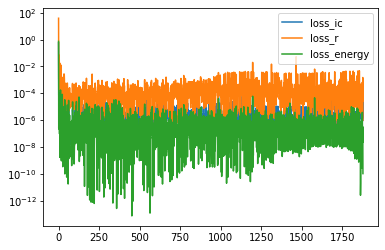

In [84]:
plt.plot(epoch_log, trainer.loss_ics_log, label='loss_ic')
plt.plot(epoch_log, trainer.loss_res_log, label='loss_r')
plt.plot(epoch_log, trainer.loss_energy_log, label='loss_energy')
plt.yscale('log')
plt.legend()
plt.savefig(f'{file}/loss.jpg')

In [ ]:
# load the data
data = scipy.io.loadmat('data/KdV.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]

In [ ]:
print(t_star.shape)
print(x_star.shape)
usol.shape

/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, '$x$')

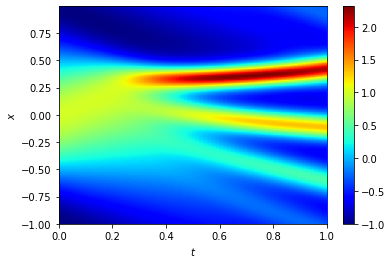

In [74]:
# load the data
data = scipy.io.loadmat('../data/KdV.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

In [ ]:
# Get trained network parameters
TX = np.hstack((TT.reshape(-1,1), XX.reshape(-1,1)))
TX = torch.from_numpy(TX).double()

model = trainer.model.cpu().double()
u_pred = model(TX).detach().numpy()
u_pred = u_pred.reshape(TT.shape)

error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol) 
print('Relative l2 error: {:.3e}'.format(error))

In [72]:
TT.shape, XX.shape, usol.shape

((512, 201), (512, 201), (512, 201))

/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':
/home/stu1/.conda/envs/pde/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarni

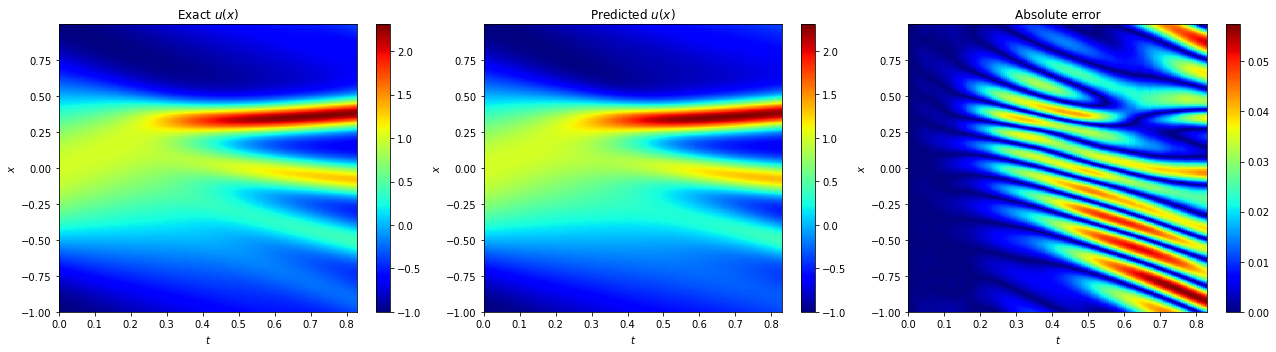

In [78]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT[:, :167], XX[:, :167], usol[:, :167], cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()


plt.subplot(1, 3, 2)
plt.pcolor(TT[:, :167], XX[:, :167], pred[:, :167], cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT[:, :167], XX[:, :167], np.abs(usol[:, :167] - pred[:, :167]), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.savefig(f'{file}/predict.jpg')

plt.show()

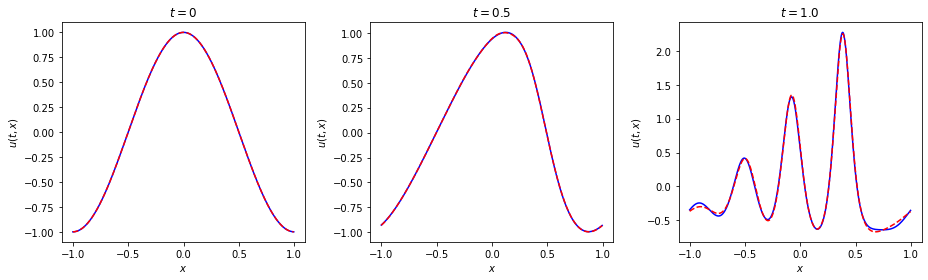

In [86]:
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:,0], color='blue')
plt.plot(x_star, pred[:,0], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:,25], color='blue')
plt.plot(x_star, pred[:,25], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0.5$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:,166], color='blue')
plt.plot(x_star, pred[:,166], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 1.0$')
plt.tight_layout()
plt.savefig(f'{file}/check_t.jpg')
plt.show()